In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque
from scipy import stats
import sys

In [21]:
alpha = 11
_lambda = 13
B = 1
N = 100000 + B
epsilon = 0.01
L = 100
initial = np.full(1, 2.5)

In [22]:
def leapfrog(theta, p, h_prime):
    half_next_p = p - (epsilon * h_prime(theta)) / 2
    next_theta = theta + epsilon * half_next_p
    next_p = half_next_p - (epsilon * h_prime(next_theta)) / 2
    return (next_p, next_theta)

In [23]:
def hamiltonian(theta, p, h):
    return (
        h(theta)
        + (
            np.sum(p ** 2) # 各次元がもつ運動エネルギーの足し合わせ
             / 2
        )
    )

In [24]:
def r(theta1, p1, theta2, p2, h):
    return (
        np.exp(hamiltonian(theta1, p1, h) - hamiltonian(theta2, p2, h))
    )

In [25]:
def hmc(h, h_prime):
    data = np.empty((N, len(initial)))
    data[0] = initial
    accept_count = 1 # data[0] は受容とみなす
    for i in range(1, N):
        if not i % 1000: # 進捗用
            sys.stdout.write("%s / %s %s %%  \r" % (i, N, np.round(100 * (i / N), decimals=2)))
            
        start_p = p = np.random.normal(0, 1, len(initial))
        start_theta = theta = data[i - 1]

        for _ in range(L):
            p, theta = leapfrog(theta, p, h_prime)

        if np.random.rand() < r(start_theta, start_p, theta, p, h):
            data[i] = theta
            accept_count = accept_count + 1
        else:
            data[i] = start_theta
            
    print("\nacceptance ratio: %s " % str(accept_count / N))
    
    return data

In [26]:
def h(x):
    """
    目標分布（事後確率）関数の対数関数のマイナス。必ずスカラー値を返却させる
    """
    return (_lambda * x) - ((alpha - 1) * np.log(x))

def h_prime(x):
    """
    目標分布関数の対数関数の微分のマイナス
    """
    return _lambda - ((alpha - 1) / x)

data = hmc(
    h,
    h_prime
)

100000 / 100001 100.0 %  
acceptance ratio: 0.999810001899981 


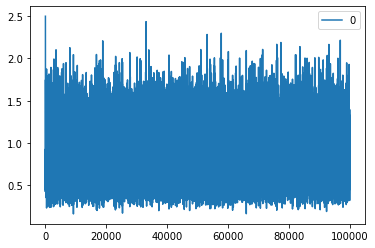

In [27]:
pd.DataFrame(data).plot()

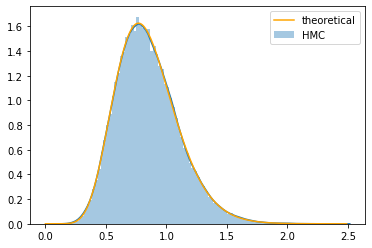

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.distplot(data[B:],bins=100, label='HMC', ax=ax)
arr = np.arange(0, 2.5, 0.01)
sns.lineplot(
    data=pd.DataFrame(
        data=stats.gamma.pdf(arr, alpha, scale=1/_lambda),
        index=arr,
        columns=['theoretical']
    ),
    ax=ax,
    palette=['orange']
)